# TDA & Deep Learning Project Perslay Application 1

Floran DEFOSSEZ
Gatien Chopard
Sebastien ROIG

Ce notebook a pour objectif de présenter l'article "PersLay: A Simple and Versatile Neural Network
Layer for Persistence Diagrams" en reprodisant un problème de classification d'orbites présenté dans l'article. C'est l'occasion pour nous de mettre en application la théorie TDA au service d'un problème de deep learning et de nous familiariser avec tensorflow

In [224]:
import matplotlib.pyplot as plt
import numpy as np
import gudhi.representations as tda
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd
import gudhi as gd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow import random_uniform_initializer as uri

## Génération du dataset

Generating orbits for r=2.5
Generating orbits for r=3.5
Generating orbits for r=4.0
Generating orbits for r=4.1
Generating orbits for r=4.3


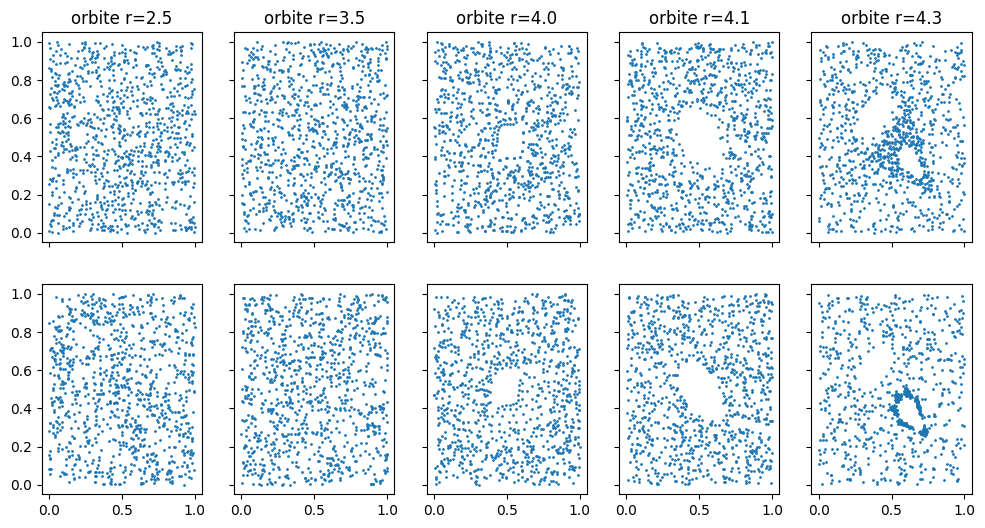

In [206]:
n_diag_per_class = 1000
r_values = [2.5, 3.5, 4.0, 4.1, 4.3]
n_class = len(r_values)
n_points = 1000

def generate_orbit(r, n_points):
    X = np.zeros((n_points, 2))
    X[0] = [np.random.rand(), np.random.rand()]
    for i in range(1, n_points):
        x = (X[i-1][0] + r * X[i-1][1] * (1. - X[i-1][1])) % 1
        y = (X[i-1][1] + r * x * (1. - x)) % 1
        X[i] = [x, y]
    return X

X = np.zeros((n_class, n_diag_per_class, n_points, 2))

fig, ax = plt.subplots(2, n_class, sharex=True, sharey=True, figsize=(12, 6))

for i,r in enumerate(r_values):
    print(f"Generating orbits for r={r}")
    for diag in range(n_diag_per_class):
        X[i,diag] = generate_orbit(r, n_points)
    ax[0][i].set_title(f"orbite r={r}")
    ax[0][i].scatter(X[i,0,:,0], X[i,0,:,1], s=1)
    ax[1][i].scatter(X[i,1,:,0], X[i,1,:,1], s=1)
plt.show()

## Pre-processing

### Diagrammes de persistance

Computing diagrammes for orbites with r=2.5
Computing diagrammes for orbites with r=3.5
Computing diagrammes for orbites with r=4.0
Computing diagrammes for orbites with r=4.1
Computing diagrammes for orbites with r=4.3


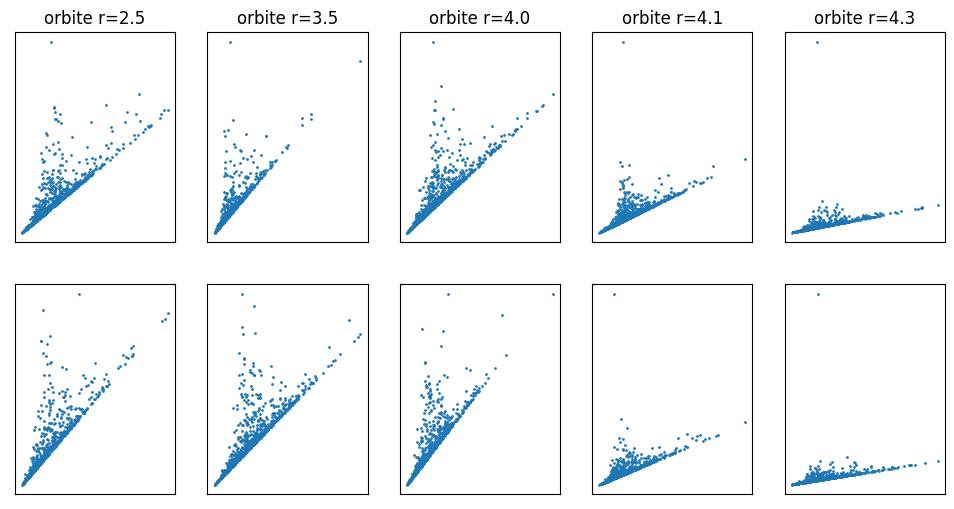

In [209]:
diags = []
labels = []
id = 0

fig, ax = plt.subplots(2, n_class, figsize=(12, 6))
plt.xticks([]) 
for i,r in enumerate(r_values):
    print(f"Computing diagrammes for orbites with r={r}")
    for diag in range(n_diag_per_class):
        alpha_complex = gd.AlphaComplex(points=X[i,diag])      
        simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1e50)
        simplex_tree.persistence()
        diags.append(np.array(simplex_tree.persistence_intervals_in_dimension(1), dtype=object))
        labels.append({"label": r, "id": id})
        id += 1
    ax[0][i].set_title(f"orbite r={r}")
    ax[0][i].scatter(diags[i*diag][:,0], diags[i*diag][:,1], s=1)
    ax[1][i].scatter(diags[i*diag + 1][:,0], diags[i*diag + 1][:,1], s=1)
    ax[0][i].get_yaxis().set_visible(False)
    ax[1][i].get_yaxis().set_visible(False)
    ax[0][i].get_xaxis().set_visible(False)
    ax[1][i].get_xaxis().set_visible(False)
labels = pd.DataFrame(labels)
labels.set_index("id")
    
plt.show()

In [213]:
n_points_diag = 500


# supprime les points à l'infini
selector = tda.DiagramSelector(use=True)
# supprime les points les plus proches de la digonale pour en garder au plus 500
prominent_point = tda.ProminentPoints(use=True, num_pts=n_points_diag)
# normalise les points du digramme sur [0,1]² par transformation linéaire
scaler = tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])
# ajoute des points pour obtenir des digrammes avec les mêmes nombre de point,
# ajoute une troisième coodronnées aux points indiquant si ils ont été ajoutés par padding
padding = tda.Padding(use=True)

diags = selector.fit_transform(diags)
diags = prominent_point.fit_transform(diags)
diags = scaler.fit_transform(diags)
diags = padding.fit_transform(diags)
diags = np.array(diags, dtype=np.float32)

### Labels

In [214]:
y = LabelEncoder().fit_transform(labels["label"])
y = OneHotEncoder(sparse=False, categories="auto").fit_transform(y[:, np.newaxis])

## Model

<img src="images/perslayModelOrbits.png"  style="width: 800px;"/>

In [215]:
class PerslayModel(tf.keras.Model):
    def __init__(self):
        super(PerslayModel, self).__init__()
        
        self.weight =  tf.Variable(name="weight", initial_value=uri(1.,1.)([10,10]), trainable=True)
        self.layer_weight = tf.Variable(name="layer_w", initial_value=uri(0.,1.)([2,25]), trainable=True)
        self.layer_bias = tf.Variable(name="layer_b", initial_value=uri(0.,1.)([25]), trainable=True)

        self.rho = tf.keras.Sequential([tf.keras.layers.Dense(5, activation="sigmoid", input_shape=(125,))])
    
    def call(self, inputs, training=False):

        tensor_mask = inputs[:, :, 2]     # garder les bons points
        tensor_diag = inputs[:, :, :2]    # les diagrammes sans masque

        # compute weights
        coords = 10 * (tensor_diag + 0.001)/1.002
        indices = tf.cast(coords, tf.int32)
        weight = tf.expand_dims(tf.gather_nd(params=self.weight, indices=indices), -1)
        
        # compute layer
        A = tf.einsum("ijk,kl->ijl", tensor_diag, self.layer_weight)
        tensor_diag =  A + self.layer_bias
        
        # Apply weight
        tiled_weight = tf.tile(weight, [1, 1, 25])
        tensor_diag = tf.math.multiply(tensor_diag, tiled_weight)

        # Apply mask
        tensor_mask = tf.expand_dims(tensor_mask, -1)
        tiled_mask = tf.tile(tensor_mask, [1, 1, 25])
        masked_layer = tf.math.multiply(tensor_diag, tiled_mask)

        # Permutation invariant operation ktop
        masked_layer_t = tf.transpose(masked_layer, perm=[0, 2, 1])
        values, indices = tf.math.top_k(masked_layer_t, k=5)
        representation = tf.reshape(values, [-1, 125])

        final_representations = self.rho(representation)

        return final_representations        

## Estimation

### Paramètres

In [216]:
model = PerslayModel()
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=1., staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [217]:
test_size = 0.3
epochs    = 100

In [218]:
num_pts = len(diags)
random_perm = np.random.permutation(num_pts)
train = random_perm[:int((1-test_size)*num_pts)]
test = random_perm[int((1-test_size)*num_pts):]

### Evaluation

In [219]:
label_train = y[train, :]
label_test = y[test, :]

diags_train = diags[train, :]
diags_test = diags[test, :]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(x=diags_train, y=label_train, validation_data=(diags_test, label_test), epochs=epochs, batch_size=128, shuffle=True, verbose=0)
train_results = model.evaluate(diags_train, label_train, verbose=0)
test_results = model.evaluate(diags_test,  label_test, verbose=0)

### Résultats

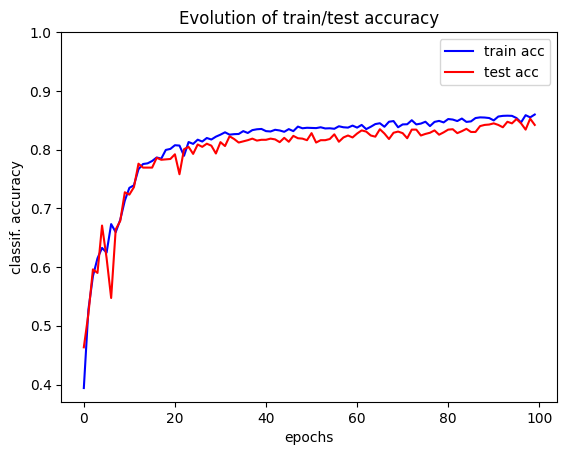

In [222]:
ltrain = history.history["categorical_accuracy"]
ltest = history.history["val_categorical_accuracy"]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.array(ltrain), color="blue", label="train acc")
ax.plot(np.array(ltest),  color="red",  label="test acc")
ax.set_ylim(top=1.)
ax.legend()
ax.set_xlabel("epochs")
ax.set_ylabel("classif. accuracy")
ax.set_title("Evolution of train/test accuracy")
plt.show()